# Прогнозирование продаж медикаментов с использованием линейной регрессии

In [102]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from matplotlib.animation import FuncAnimation
import seaborn as sn
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

import plotly.graph_objects as go


In [103]:
#Загружаем данные
data = pd.read_csv('/content/MedicineData.csv')
data

,date,R03
0,1/1/1992,1509
1,2/1/1992,1541
2,3/1/1992,1597
3,4/1/1992,1675
4,5/1/1992,1822
...,...,...
319,8/1/2018,4898
320,9/1/2018,4598
321,10/1/2018,4737
322,11/1/2018,5130


In [104]:
# Переименуем столбец и переформатируем дату для удобства
data = data.rename(columns={'R03': 'sales'})
data['date'] = pd.to_datetime(data['date'], format="%m/%d/%Y")
data['date'] = data['date'].dt.strftime("%Y-%m-%d")

print(data)


           date  sales
0    1992-01-01   1509
1    1992-02-01   1541
2    1992-03-01   1597
3    1992-04-01   1675
4    1992-05-01   1822
..          ...    ...
319  2018-08-01   4898
320  2018-09-01   4598
321  2018-10-01   4737
322  2018-11-01   5130
323  2018-12-01   6370

[324 rows x 2 columns]


In [105]:
#Создаем копию исходных данных, преображуем дату в индекс, а также отсортируем данные по времени
df = data.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()
reg_df = df.copy()

In [106]:
#Генерируем фичи
for i in range(1, 8):
    reg_df[f'lag_{i}'] = reg_df.sales.shift(i)
reg_df['rolling_mean'] = reg_df.sales.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.sales.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.sales.rolling(window=7).min()

reg_df = reg_df.dropna()

In [107]:
#Делим датасет на тренировочную и валидационную часть
last_date = reg_df.index.max()
val_start = last_date - pd.DateOffset(months=11)

In [108]:
reg_train_df = reg_df.loc[:val_start - pd.Timedelta(days=1)]
reg_val_df   = reg_df.loc[val_start:]

print("Train:", reg_train_df.index.min(), "-", reg_train_df.index.max())
print("Val:  ", reg_val_df.index.min(), "-", reg_val_df.index.max())

Train: 1992-08-01 00:00:00 - 2017-12-01 00:00:00
Val:   2018-01-01 00:00:00 - 2018-12-01 00:00:00


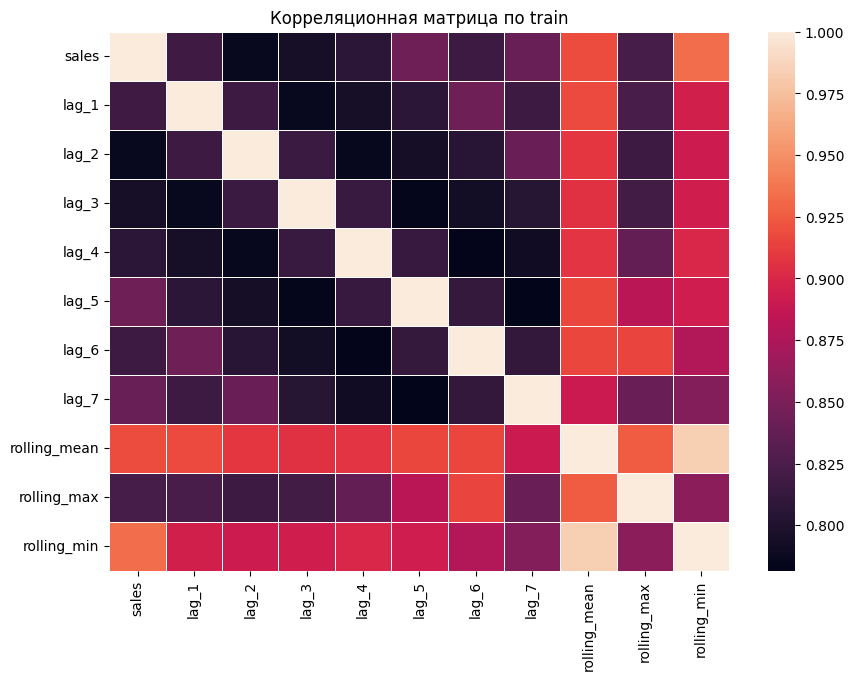

In [109]:
#анализ корреляции
corr = reg_train_df.corr()
plt.figure(figsize=(10,7))
sn.heatmap(corr, linewidths=.5)
plt.title("Корреляционная матрица по train")
plt.show()

In [110]:
#Подготовка выборок
X_train, y_train = reg_train_df.drop(['sales'], axis=1), reg_train_df['sales']
X_val, y_val     = reg_val_df.drop(['sales'], axis=1), reg_val_df['sales']

In [111]:
#Отбор лучших признаков
top_features = SelectKBest(score_func=f_regression, k=5)
top_features.fit(X_train, y_train)

best_cols = list(X_train.columns[top_features.get_support()])
print("Топ фич:", best_cols)

X_train, X_val = X_train[best_cols], X_val[best_cols]

Топ фич: ['lag_5', 'lag_7', 'rolling_mean', 'rolling_max', 'rolling_min']


In [112]:
#Обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

pred_val = model.predict(X_val)

In [113]:
#Расчет метрик
def print_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f'MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')
print_metrics(y_val, pred_val, "Валидация")


MAE: 359.55876052953846, RMSE: 458.18695697172, MAPE: 0.07606255228947868


In [123]:
#Анализируем полученные данные
errors_val = reg_val_df[['sales']].copy()
errors_val['прогноз'] = pred_val
errors_val['ошибка'] = pred_val - y_val

errors_df = pd.concat([errors_val])
errors_df

,sales,прогноз,ошибка
date,,,
2018-01-01,3965,4505.078936,540.078936
2018-02-01,3967,4704.757681,737.757681
2018-03-01,4629,4668.595464,39.595464
2018-04-01,4317,4708.108230,391.108230
2018-05-01,4897,4729.054067,-167.945933
2018-06-01,4939,4632.033067,-306.966933
2018-07-01,4963,4882.305361,-80.694639
2018-08-01,4898,4135.968793,-762.031207
2018-09-01,4598,4705.440982,107.440982


In [117]:
#Визуализация
fig = go.Figure()

fig.add_scatter(x=reg_train_df.index, y=reg_train_df['sales'], name='Факты (train)')
fig.add_scatter(x=reg_val_df.index, y=reg_val_df['sales'], name='Факты (val)')
fig.add_scatter(x=reg_val_df.index, y=pred_val, name='Прогноз (val)')

fig.update_layout(title="Продажи", template="plotly_white")

fig.show()